## Практика

In [2]:
#Импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing

#Загрузим данные
df = pd.read_csv('data/segmented_customers.csv')
#Посмотрим на данные
display(df.head())

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


In [3]:
#Проведем продбработку данных

#Посмотрим есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [4]:
#Пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

#Переименуем столбцы для более удобной работы
df.rename(columns= {'CustomerID':'customer_id',
                    'Gender':'gender',
                    'Age': 'age',
                    'Annual Income (k$)': 'annual_income',
                    'Spending Score (1-100)': 'spending_score'},
          inplace = True)

In [6]:
#Проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score,cluster


Чтобы мы могли визуально оценивать результаты кластеризации, будем проводить её по трём признакам, а именно: годовой заработок, коэффициент покупательской способности и возраст.

In [7]:
#Импортируем библиотеки
import plotly 
import plotly.express as px

#Передаем датафрейм и поля, которые нужно использовать для осей x, y и z
fig = px.scatter_3d(
    data_frame=df,
    x = 'age',
    y = 'annual_income',
    z = 'spending_score', 
    width = 1000, 
    height = 700 
)
#Отображаем график
fig.show()

Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию. Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации. Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score), зафиксируем их названия внутри функции

In [8]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df,
        x = 'age',
        y = 'annual_income',
        z = 'spending_score',
        color = clust_res,
        width = 1000,
        height = 700
    )
    #Возвращаем график
    return fig

In [9]:
#Сохраним признаки, по которым будем проводить моделирование
X = df[['age', 'annual_income', 'spending_score']]

### Задание 10.1

In [15]:
#Импортируем DBSCAN-кластеризацию
from sklearn.cluster import DBSCAN

#Запускаем кластеризацию наших данных
dbscan = DBSCAN()
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res')


In [16]:
#Алгоритм плохо работает с настройками по умолчанию, попробуем их изменить

#Запускаем кластеризацию наших данных
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')



Самостоятельно играемся с eps и min_samples

In [31]:
#Запускаем кластеризацию наших данных
dbscan = DBSCAN(eps=11, min_samples=5)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_and_min_samp'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_and_min_samp')


Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками

In [32]:
#Импортируем агломеративную кластеризацию 
from sklearn.cluster import AgglomerativeClustering

#Напишем функцию, которая будет проводить агломеративную кластеризацию
#На вход она будет принимать X - матрицу с признаками для кластеризации 
#и n_clusters - количество кластеров
#На выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    #Запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    #Обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    #Получим список с информацией, к какому кластеру относятся бъекты
    aggl_prediction = agglomerative_clustering.labels_
    #Вернем список с результатами
    return aggl_prediction


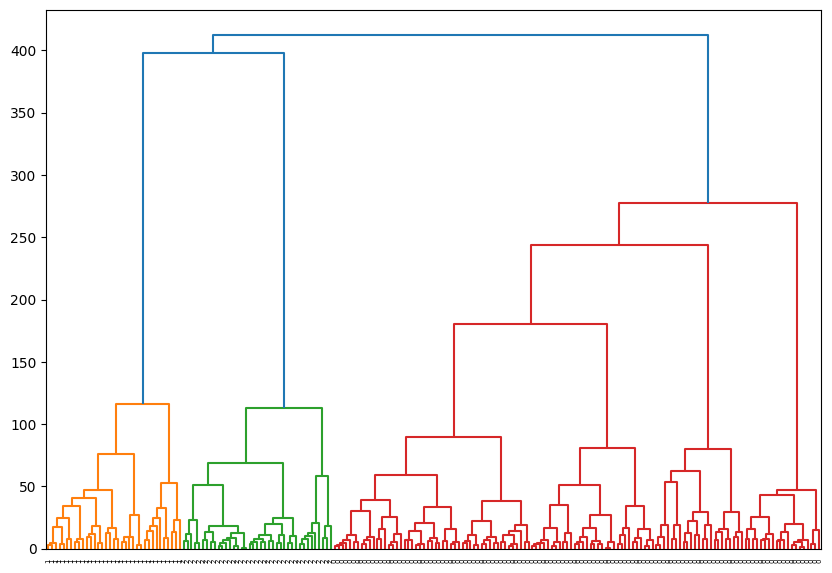

In [37]:
#Провести кластеризацию и визуализировать полученную дендрограмму
df['aggl_res_3'] = get_aggl_clustering(X, n_clusters=3)

#Визуализируем результаты
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

#Рассчитываем расстояния между кластерами
linked = linkage(X, 'ward')

plt.figure(figsize=(10,7))

#Визуализируем дендрограмму с ориентацией top
#Сначала будут отрисовываться кластеры с минимальным 
#расстоянием между ними
dendrogram(Z=linked,
           orientation='top',
           labels=df['aggl_res_3'].to_list(),
           distance_sort='descending',
           show_leaf_counts=True)
plt.show()

Как мы можем судить из дендрограммы, если взять евклидово расстояние между кластерами, равное 150, датасет будет делиться на шесть кластеров

In [38]:
#Обучим модель агломеративной кластеризации с количеством кластеров = 6

df['aggl_res_6'] = get_aggl_clustering(X, n_clusters=6)
get_3d_visualization(df, 'aggl_res_6')

### Задание 10.4
Для агломеративной кластеризации самостоятельно с помощью коэффициента силуэта подберите оптимальное количество кластеров. Сколько кластеров у вас получилось?

<Axes: xlabel='cluster', ylabel='silhouette'>

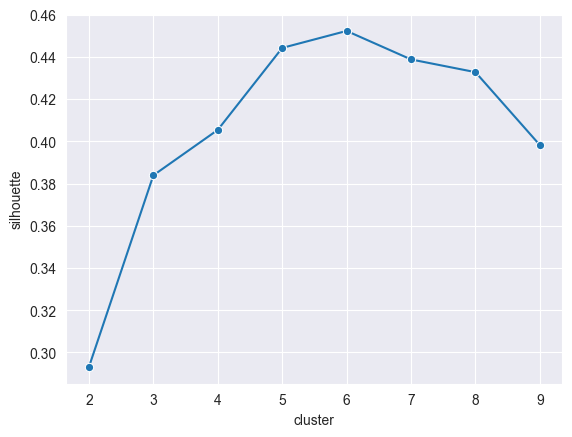

In [39]:
#Посчитаем силуэт, используя sklearn

#Импортируем необходимые библиотеки
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

#Напишем функцию
def get_silhouette(cluster_num, X):
    k_means = KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(X)
    #Подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette

#Создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {'silhouette': [], 'cluster': []}


for cluster_num in range(2, 10):
    silhouette_res['silhouette'].append(get_silhouette(cluster_num, X))
    silhouette_res['cluster'].append(cluster_num)
    
#Сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

#Установим стиль для визуализации
sns.set_style('darkgrid')
#Визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x='cluster', y='silhouette', marker='o')

In [45]:
#Вызовем метрику полноты для оценки качества модели
from sklearn.metrics.cluster import completeness_score

print('Score метрики полноты : {:.3f}'.format(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6)))

Score метрики полноты : 0.901
